In [1]:
!pip install git+https://github.com/fchollet/stable-diffusion-tensorflow --upgrade --quiet
!pip install tensorflow tensorflow_addons ftfy --upgrade --quiet
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2


Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


  0   1: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


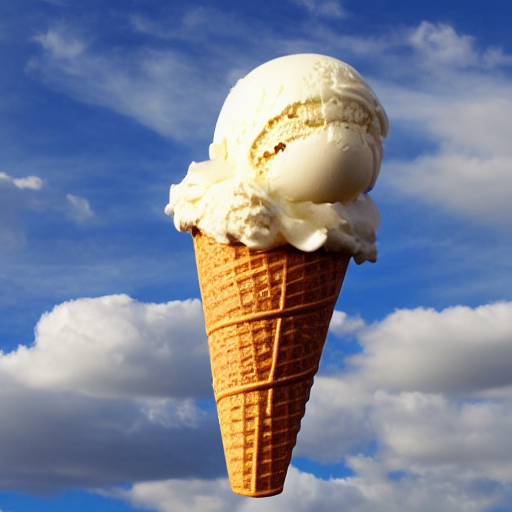

In [2]:
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image

generator = Text2Image( 
    img_height=512,
    img_width=512,
    jit_compile=False,
)
img = generator.generate(
    "The big ice cream cone in the sky",
    num_steps=50,
    unconditional_guidance_scale=7.5,
    temperature=1,
    batch_size=1,
)
pil_img = Image.fromarray(img[0])
display(pil_img)

In [14]:
import tensorflow as tf

In [15]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

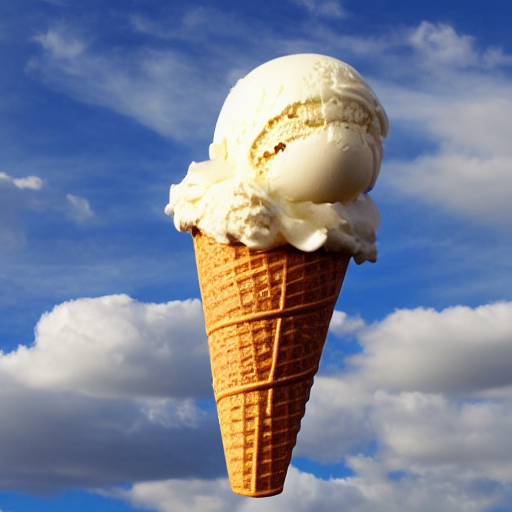

In [16]:
def download(img, max_dim=None):
  # name = img.split('/')[-1]
  # image_path = tf.keras.utils.get_file(name, origin=img)
  # img = PIL.Image.open(image_path)
  # if max_dim:
  #   img.thumbnail((max_dim, max_dim))
  return np.array(img)

def deprocess(img):
  img = 255*(img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

original_img = download(pil_img, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [17]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [18]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [19]:
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]
  
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
  
  return tf.reduce_sum(losses)

In [20]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model
  
  @tf.function(
      input_signature=(
          tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
          tf.TensorSpec(shape=[], dtype=tf.int32),
          tf.TensorSpec(shape=[], dtype=tf.float32),
      )
  )
  def __call__(self, img, steps, step_size):
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, self.model)
      
      gradients = tape.gradient(loss, img)

      gradients /= tf.math.reduce_std(gradients) + 1e-8

      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)
    
    return loss, img

In [21]:
deepdream = DeepDream(dream_model)

In [22]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining > 100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print("Step {}, loss {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

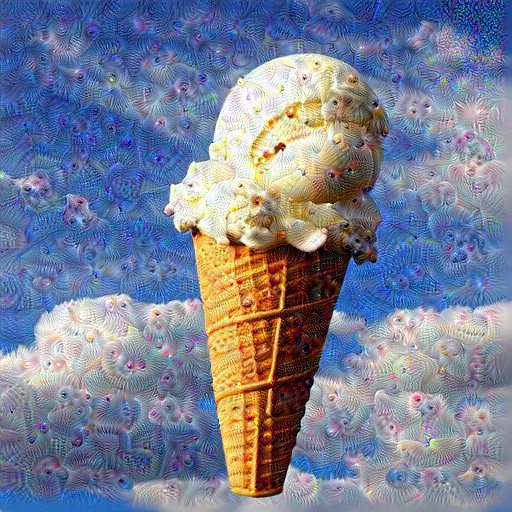

In [12]:
dream_img = run_deep_dream_simple(
    img=original_img, 
    steps=100,
    step_size=0.01
)

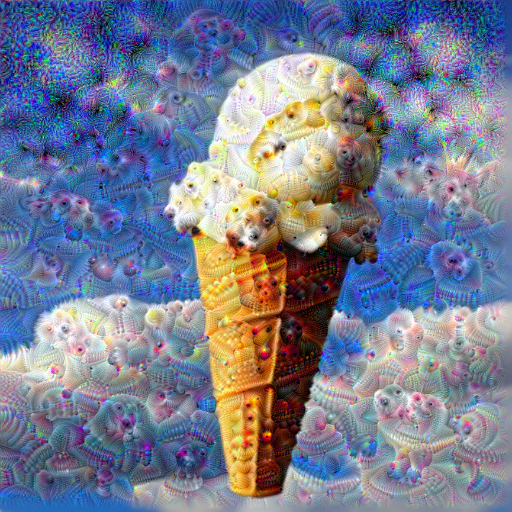

20.47955846786499

In [13]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start